# 4. Bayesian Networks

This notebook will show you how to query the main class of this package: `thomas.core.BayesianNetwork`.

In [1]:
%run '_preamble.ipynb'

Python version: 3.8.10
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

available imports:
  import os
  import logging
  import pandas as pd
  import numpy as np

connect to this kernel with:
  jupyter console --existing 4011a28c-a690-46f4-b0c4-c42d9a2f126b

Could not create logging directory "../logs"
Logging to: "../logs/notebook.log"
Current date/time: 11-06-2021, 21:29
Current working directory: "/Users/melle/software-development/thomas-master/notebooks"


In [2]:
from thomas.core.models.bn import BayesianNetwork
from thomas.core import examples
from thomas.core.reader import oobn

from IPython.display import display, HTML

## Student example

In [3]:
# Load the Student Network from the examples
Gs = examples.get_student_network()
Gs

<BayesianNetwork name='Student'>
  <Node RV='I' description='Intelligence' states=['i0', 'i1'] />
  <Node RV='S' description='SAT Score' states=['s0', 's1'] />
  <Node RV='D' description='Difficulty' states=['d0', 'd1'] />
  <Node RV='G' description='Grade' states=['g1', 'g2', 'g3'] />
  <Node RV='L' description='Letter' states=['l0', 'l1'] />
</BayesianNetwork>

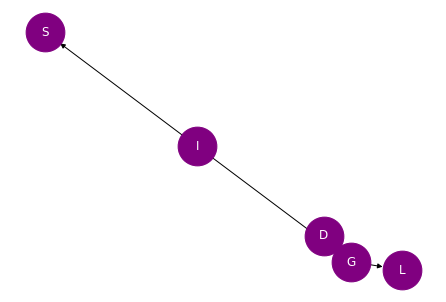

In [4]:
# Show the network and its relations
Gs.draw()

In [5]:
# Nodes can be accessed by using the BN as a `dict`:
Gs['S']

DiscreteNetworkNode('S', name='S', states=['s0', 's1'], description='SAT Score')

In [6]:
# The Node-property 'states' will return a list of allowed states.
Gs['S'].states

['s0', 's1']

In [7]:
# Accessing individual Nodes/CPTs is easy
Gs['S'].cpt

S,s0,s1
I,,
i0,0.95,0.05
i1,0.20,0.80


In [8]:
# Querying the network is also simple. To compute the marginals over I, S and D:
Gs.compute_marginals(['I', 'S', 'D'])

{'I': factor(I)
 I 
 i0    0.7
 i1    0.3
 dtype: float64,
 'S': factor(S)
 S 
 s0    0.725
 s1    0.275
 dtype: float64,
 'D': factor(D)
 D 
 d0    0.6
 d1    0.4
 dtype: float64}

In [9]:
# To compute the marginals over I, S and D given evidence I=i0:
Gs.compute_marginals(['I', 'S', 'D'], {'I':'i0'})

{'I': factor(I)
 I 
 i0    1.0
 i1    0.0
 dtype: float64,
 'S': factor(S)
 S 
 s0    0.95
 s1    0.05
 dtype: float64,
 'D': factor(D)
 D 
 d0    0.6
 d1    0.4
 dtype: float64}

In [10]:
# Complex queries can be run simply by providing the query as string:
Gs.P('I=i0|S')

array([0.91724138, 0.12727273])

In [11]:
# This should be equal to Gs['S']
Gs.P('S|I')

S,s0,s1
I,,
i0,0.95,0.05
i1,0.20,0.80


In [20]:
Gs.S.cpt

S,s0,s1
I,,
i0,0.95,0.05
i1,0.20,0.80


In [12]:
# Alternatively, parameters can be specified separately through 
# `compute_posterior()`:
Gs.compute_posterior(qd=['I'], qv={}, ed=['S'], ev={})

I,i0,i1
S,,
s0,0.9172,0.0828
s1,0.1273,0.8727


In [13]:
# A CPT can be converted to a pandas.DataFrame by calling `unstack()` without
# parameters. Note that this only works if there are conditioning variables.
unstacked = Gs.P('I|S').as_series().unstack()
print(f'type(unstacked): {type(unstacked)}')
print()
display(unstacked)

type(unstacked): <class 'pandas.core.frame.DataFrame'>



I,i0,i1
S,,
s0,0.917241,0.082759
s1,0.127273,0.872727


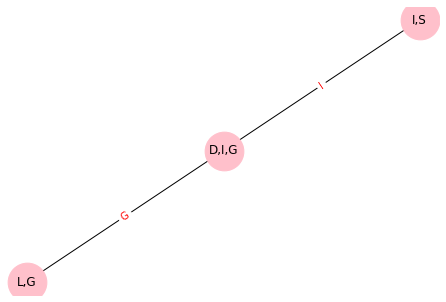

In [14]:
# The junction tree (jointree) can be inspected by calling `jt.draw()`:
Gs.jt.draw()

## Importing Bayesian Networks

`thomas` supports loading Bayesian Networks from different file formats:
* `.net`: the Netica file format
* `.oobn`: the Hugin Object Oriented Bayesian Network file format
* `.json`: thomas' custom, JSON based format.

As an example, we'll open an `oobn` file.

In [15]:
from thomas.core.reader import oobn, net

In [16]:
# Read a file in OOBN format
filename = thomas.core.get_pkg_filename('lungcancer.oobn')
bn = oobn.read(filename)

bn.P('death').as_factor()

factor(death)
death      
0-30 days      0.0829
1-4 months     0.2124
4-6 months     0.0988
6-12 months    0.1992
1-2 years      0.1810
> 2 years      0.2257
dtype: float64

In [17]:
# Read a file in NET format
filename = thomas.core.get_pkg_filename('lungcancer.net')
bn = net.read(filename)

bn.P('death').as_factor()

factor(death)
death      
0-30 days      0.0829
1-4 months     0.2124
4-6 months     0.0988
6-12 months    0.1992
1-2 years      0.1810
> 2 years      0.2257
dtype: float64

In [18]:
# Download and read another file in NET format
import requests
import gzip

filename = 'asia.net'

if not os.path.exists(filename):
    url = 'https://www.bnlearn.com/bnrepository/asia/asia.net.gz'
    target_path = 'asia.net.gz'
    print(f'Current directory: "{os.getcwd()}"')
    print(f'Downloading "{target_path}" from "{url}"')

    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(target_path, 'wb') as f:
            f.write(response.raw.read())

        print(f'Unzipping "{target_path}"')
        data = gzip.open(target_path)

        print(f'Saving "{filename}"')
        with open(filename, 'wb') as fp:
            fp.write(data.read())

    else:
        print('ERROR: Could not download file!?')

bn = net.read(filename)
display(bn.P('asia'))

asia,yes,no
,0.01,0.99
